Traffic Flow Prediction with Autoencoders, Batch Normalization, and Gradient Descent

Objective: Investigate how batch normalization and different gradient descent methods affect traffic flow prediction, using autoencoders for feature reduction.

Tasks:
Autoencoder: Implement an autoencoder to preprocess and compress traffic data.

Neural Network Model: Build a model for predicting traffic congestion with batch normalization layers.

Optimization:

Train the model using:

- Full batch gradient descent
- Mini-batch gradient descent
- Stochastic gradient descent

Comparison: Compare training efficiency, convergence speeds, and prediction accuracy for each gradient descent method.

Optimizers: Use Adam and Adagrad optimizers.

Deliverables: Jupyter notebook with code, explanations, and results.

A report analyzing the impact of batch normalization and different gradient descent methods, including the role of autoencoders.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
traffic_df = pd.read_csv('/content/synthetic_traffic_data_with_congestion.csv')
traffic_df['Time'] = pd.to_datetime(traffic_df['Time'])
traffic_df

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion
0,2024-01-01 00:00:00,102.0,95.208871,71.489953,24.730232,6.641042,1.613307,4.843614,5.615359,Snowy,Low
1,2024-01-01 01:00:00,435.0,22.227414,57.897765,8.805837,17.086020,27.731161,6.546673,0.003330,Snowy,Medium
2,2024-01-01 02:00:00,860.0,110.130299,1.460900,23.678285,31.112068,19.851620,19.707152,1.142456,Wet,High
3,2024-01-01 03:00:00,270.0,50.943291,36.037549,33.260058,32.069929,26.598680,7.363360,3.751952,Dry,Low
4,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowy,Low
...,...,...,...,...,...,...,...,...,...,...,...
2995,2024-05-04 19:00:00,908.0,8.085225,19.574603,-9.857157,39.042333,29.211387,1.396254,9.959174,Dry,High
2996,2024-05-04 20:00:00,158.0,99.784894,82.674243,33.180766,38.136846,14.165901,3.205072,9.941294,Wet,Low
2997,2024-05-04 21:00:00,582.0,21.279186,83.076739,16.645546,26.269763,11.807877,8.543912,4.240304,Wet,Medium
2998,2024-05-04 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wet,High


In [4]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time                3000 non-null   datetime64[ns]
 1   Traffic_Flow        2700 non-null   float64       
 2   Average_Speed       2700 non-null   float64       
 3   Occupancy           2700 non-null   float64       
 4   Temperature         2700 non-null   float64       
 5   Humidity            2700 non-null   float64       
 6   Wind_Speed          2700 non-null   float64       
 7   Precipitation       2700 non-null   float64       
 8   Visibility          2700 non-null   float64       
 9   Road_Condition      2850 non-null   object        
 10  Traffic_Congestion  3000 non-null   object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 257.9+ KB


In [5]:
traffic_df.describe()

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility
count,3000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,2024-03-03 11:30:00,502.494444,59.921518,49.843010,12.754635,49.845469,14.942475,9.945241,5.010733
min,2024-01-01 00:00:00,0.000000,0.022383,0.062752,-9.953997,0.011864,0.005265,0.000186,0.003330
25%,2024-02-01 05:45:00,243.000000,29.808424,25.456106,1.962071,25.582698,7.648250,4.789890,2.523476
50%,2024-03-03 11:30:00,502.000000,60.362272,50.356672,12.936843,49.857398,14.813953,9.949895,4.921099
75%,2024-04-03 17:15:00,763.000000,90.024442,74.385113,23.876495,74.001263,22.121859,14.974315,7.577471
max,2024-05-04 23:00:00,998.000000,119.965656,99.984924,34.988357,99.966964,29.996780,19.993897,9.995181
std,NaN,294.856683,34.644438,28.817498,12.924307,28.651388,8.575421,5.799578,2.892501


In [6]:
traffic_df.duplicated().sum()

np.int64(0)

In [7]:
traffic_df[traffic_df.isna().sum(axis=1) != 0]

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion
4,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowy,Low
7,2024-01-01 07:00:00,20.0,63.179903,30.880228,17.168493,21.126373,26.996792,6.489068,4.296014,NaN,Low
13,2024-01-01 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowy,Medium
16,2024-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dry,Low
36,2024-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Icy,High
...,...,...,...,...,...,...,...,...,...,...,...
2976,2024-05-04 00:00:00,647.0,77.050381,74.836083,28.757885,96.625371,7.228561,3.760505,2.305994,NaN,Medium
2977,2024-05-04 01:00:00,143.0,33.064388,78.392859,0.075779,97.380185,13.393358,18.873001,5.868893,NaN,Low
2982,2024-05-04 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dry,Low
2991,2024-05-04 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Icy,Medium


In [8]:
traffic_df['Road_Condition'].value_counts(dropna=False), traffic_df['Traffic_Congestion'].value_counts(dropna=False)

(Road_Condition
 Dry      738
 Snowy    733
 Icy      714
 Wet      665
 NaN      150
 Name: count, dtype: int64,
 Traffic_Congestion
 High      1020
 Low        990
 Medium     990
 Name: count, dtype: int64)

In [9]:
traffic_df['Road_Condition'] = traffic_df['Road_Condition'].map({'Dry': 0, 'Snowy': 1, 'Icy': 2, 'Wet': 3})

In [10]:
imputer = KNNImputer(n_neighbors=5)

na_cols = ['Traffic_Flow', 'Average_Speed', 'Occupancy', 'Temperature',
       'Humidity', 'Wind_Speed', 'Precipitation', 'Visibility',
       'Road_Condition']

traffic_df[na_cols] = imputer.fit_transform(traffic_df[na_cols])

In [11]:
traffic_df[['Traffic_Congestion', 'Road_Condition']] = traffic_df[['Traffic_Congestion', 'Road_Condition']].round()

In [12]:
traffic_df.isna().sum()

,0
Time,0
Traffic_Flow,0
Average_Speed,0
Occupancy,0
Temperature,0
Humidity,0
Wind_Speed,0
Precipitation,0
Visibility,0
Road_Condition,0


In [13]:
ohe = OneHotEncoder(sparse_output=False)

encoded_df = pd.DataFrame(ohe.fit_transform(traffic_df[['Traffic_Congestion']]), columns=ohe.get_feature_names_out(['Traffic_Congestion']))
traffic_df = pd.concat([traffic_df, encoded_df], axis=1)
traffic_df.drop(columns=['Traffic_Congestion'], inplace=True)
traffic_df

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion_High,Traffic_Congestion_Low,Traffic_Congestion_Medium
0,2024-01-01 00:00:00,102.0,95.208871,71.489953,24.730232,6.641042,1.613307,4.843614,5.615359,1.0,0.0,1.0,0.0
1,2024-01-01 01:00:00,435.0,22.227414,57.897765,8.805837,17.086020,27.731161,6.546673,0.003330,1.0,0.0,0.0,1.0
2,2024-01-01 02:00:00,860.0,110.130299,1.460900,23.678285,31.112068,19.851620,19.707152,1.142456,3.0,1.0,0.0,0.0
3,2024-01-01 03:00:00,270.0,50.943291,36.037549,33.260058,32.069929,26.598680,7.363360,3.751952,0.0,0.0,1.0,0.0
4,2024-01-01 04:00:00,188.0,59.785781,23.855823,6.337066,52.913774,11.880599,11.895819,4.510378,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2024-05-04 19:00:00,908.0,8.085225,19.574603,-9.857157,39.042333,29.211387,1.396254,9.959174,0.0,1.0,0.0,0.0
2996,2024-05-04 20:00:00,158.0,99.784894,82.674243,33.180766,38.136846,14.165901,3.205072,9.941294,3.0,0.0,1.0,0.0
2997,2024-05-04 21:00:00,582.0,21.279186,83.076739,16.645546,26.269763,11.807877,8.543912,4.240304,3.0,0.0,0.0,1.0
2998,2024-05-04 22:00:00,222.6,75.680783,45.539696,-2.914846,55.371205,14.600576,10.762127,1.167719,3.0,1.0,0.0,0.0


<Axes: >

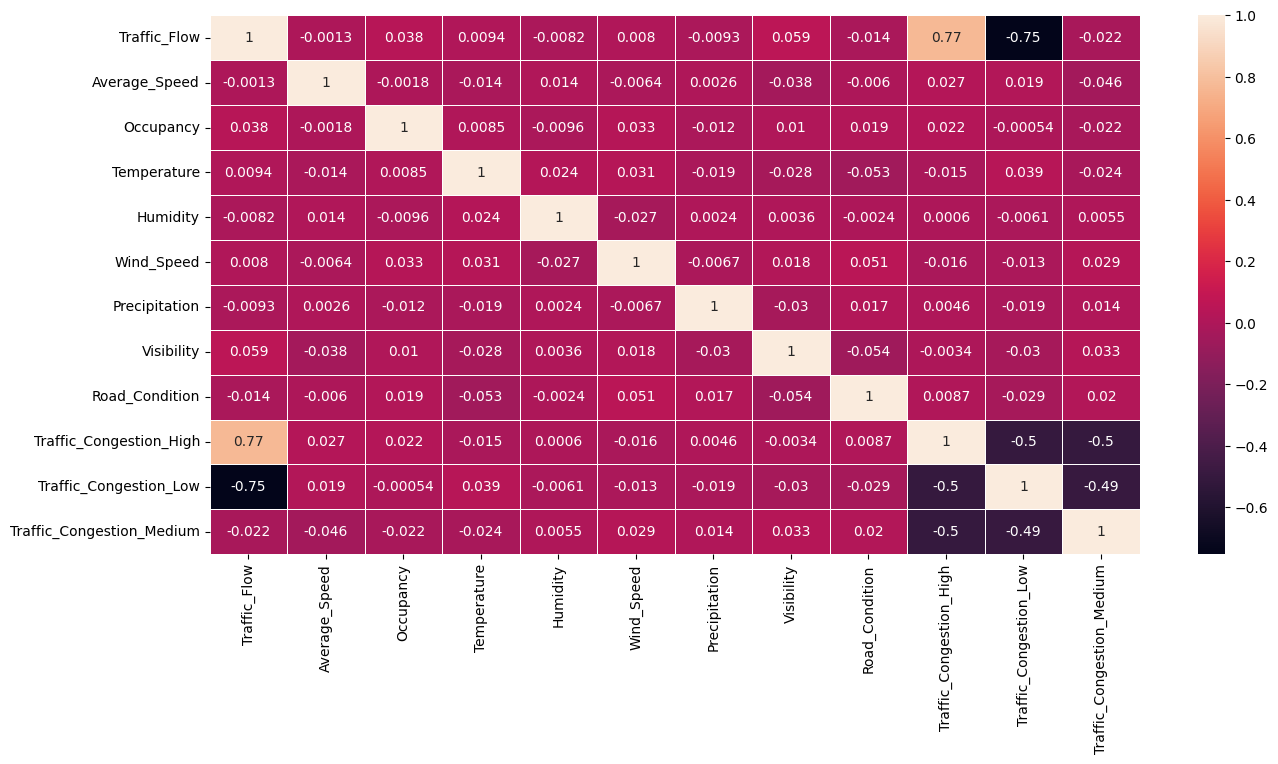

In [14]:
plt.figure(figsize=(15,7))
sns.heatmap(traffic_df.drop(columns=['Time']).corr(), annot=True, linewidths=0.5)

In [15]:
traffic_df.drop(columns='Time', inplace=True)

In [16]:
scaler = StandardScaler()

cols = traffic_df.columns.tolist()
cols = cols[:-3]

traffic_df[cols] = scaler.fit_transform(traffic_df[cols])

In [17]:
traffic_df

,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion_High,Traffic_Congestion_Low,Traffic_Congestion_Medium
0,-1.343110,1.048457,0.819613,0.980828,-1.607939,-1.635065,-0.907435,0.274489,-0.421051,0.0,1.0,0.0
1,-0.183334,-1.162538,0.328421,-0.277149,-1.224722,1.564707,-0.600997,-1.713641,-0.421051,0.0,0.0,1.0
2,1.296860,1.500506,-1.711083,0.897727,-0.710117,0.599362,1.767015,-1.310092,1.416263,1.0,0.0,0.0
3,-0.757998,-0.292582,-0.461559,1.654657,-0.674974,1.425963,-0.454048,-0.385646,-1.339709,0.0,1.0,0.0
4,-1.043588,-0.024696,-0.901780,-0.472174,0.089769,-0.377190,0.361494,-0.116964,-0.421051,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.464035,-1.590980,-1.056493,-1.751466,-0.419163,1.746053,-1.527731,1.813340,-1.339709,1.0,0.0,0.0
2996,-1.148072,1.187089,1.223788,1.648393,-0.452384,-0.097211,-1.202264,1.807005,1.416263,0.0,1.0,0.0
2997,0.328639,-1.191265,1.238334,0.342163,-0.887778,-0.386099,-0.241627,-0.212641,1.416263,0.0,0.0,1.0
2998,-0.923083,0.456847,-0.118172,-1.203045,0.179930,-0.043958,0.157504,-1.301142,1.416263,1.0,0.0,0.0


In [18]:
X = traffic_df.drop(columns=['Traffic_Congestion_Low', 'Traffic_Congestion_Medium', 'Traffic_Congestion_High'])
y = traffic_df[['Traffic_Congestion_Low', 'Traffic_Congestion_Medium', 'Traffic_Congestion_High']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 9), (600, 9), (2400, 3), (600, 3))

In [20]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [21]:
class TrafficAutoEncoder(nn.Module):
    def __init__(self, input_dim, encode_dim) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encode_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encode_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [22]:
input_dim, output_dim = X_train.shape[1], 6

autoencoder = TrafficAutoEncoder(input_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

In [23]:
epochs = 500
for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0

    for features, targets in train_loader:
        ouputs = autoencoder(features)
        loss = criterion(ouputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = autoencoder(features)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    if (epoch+1) % 50 == 0:
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Test Loss: {test_loss / len(test_loader):.4f}')

Epoch: 50, Train Loss: 0.4111, Test Loss: 0.3795
Epoch: 100, Train Loss: 0.3577, Test Loss: 0.3297
Epoch: 150, Train Loss: 0.3335, Test Loss: 0.2925
Epoch: 200, Train Loss: 0.2745, Test Loss: 0.2178
Epoch: 250, Train Loss: 0.2499, Test Loss: 0.1869
Epoch: 300, Train Loss: 0.2264, Test Loss: 0.1660
Epoch: 350, Train Loss: 0.2185, Test Loss: 0.1548
Epoch: 400, Train Loss: 0.2112, Test Loss: 0.1478
Epoch: 450, Train Loss: 0.2069, Test Loss: 0.1419
Epoch: 500, Train Loss: 0.1960, Test Loss: 0.1406


In [24]:
class TrafficDataset(Dataset):
    def __init__(self, data) -> None:
        super().__init__()
        self.X = data[:, :-3]
        self.y = data[:,-3:]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
autoencoder.eval()
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(X_train_tensor)
    X_test_encoded = autoencoder.encoder(X_test_tensor)

X_train_encoded = X_train_encoded.cpu().detach().numpy()
X_test_encoded = X_test_encoded.cpu().detach().numpy()

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=[f'encoded_{i}' for i in range(X_train_encoded.shape[1])], index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=[f'encoded_{i}' for i in range(X_test_encoded.shape[1])], index=X_test.index)

display(X_train_encoded_df)
display(X_test_encoded_df)

,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5
642,-0.067517,-0.443294,-0.728561,0.228120,-2.010679,-0.382646
700,-0.000809,-0.385559,0.262114,-0.410914,-0.713203,0.023915
226,-2.060205,-1.289537,-0.236361,0.120251,-1.473926,-0.447943
1697,-0.889476,-0.736760,0.667446,-0.285431,0.369048,0.622392
1010,-0.264982,-0.606518,0.381004,-0.292428,-0.042932,0.918155
...,...,...,...,...,...,...
1638,-0.717891,-0.741265,1.123249,-2.331742,-0.203888,0.302129
1095,-0.200496,0.536916,-0.213370,-0.607515,-0.831492,-0.073336
1130,-0.883898,-1.783031,-1.175283,0.174335,-1.772333,0.113183
1294,-0.551852,-1.926169,0.445625,-1.127870,-0.787674,0.474148


,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5
1801,-1.479660,-1.260071,0.531819,-0.906182,-0.867331,-0.717715
1190,-0.187987,-0.145335,0.212380,0.120620,-0.085197,-0.270102
1817,-0.669741,0.427508,-0.152643,-0.273684,-1.279628,-0.659026
251,0.052166,-0.439387,-0.322814,-0.795232,-0.325213,0.071336
2505,0.635322,-0.745630,-1.145032,-0.983664,0.028327,-1.023241
...,...,...,...,...,...,...
104,-1.736266,-1.520803,-0.091133,0.271340,-0.069423,0.699818
2087,-0.296349,0.085343,0.514604,-1.127405,-2.567934,-0.421982
599,1.191324,0.382181,1.209111,2.162158,-3.548226,-0.502773
1756,0.332767,-0.359951,0.946326,-0.489274,-1.504442,0.305967


In [26]:
train_df = pd.concat([X_train_encoded_df, y_train], axis=1)
test_df = pd.concat([X_test_encoded_df, y_test], axis=1)

In [27]:
train_tensor = torch.tensor(train_df.values, dtype=torch.float32).to(device)
test_tensor = torch.tensor(test_df.values, dtype=torch.float32).to(device)

In [28]:
train_dataset = TrafficDataset(train_tensor)
test_dataset = TrafficDataset(test_tensor)

In [29]:
class TrafficModel(nn.Module):
    def __init__(self, input_dim, num_classes=3) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
    def forward(self, x):
        return self.network(x)

In [30]:
class TrafficModelNoBN(nn.Module):
    def __init__(self, input_dim, num_classes=3) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
    def forward(self, x):
        return self.network(x)

In [31]:
# Batch, mini-batch, SGD
# Adam, Adagrad

In [32]:
def train_model(model, criterion, optimizer, data_loader, test_df, num_epochs, gradient_descent_method, device):
    "Training model"
    model.train()
    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_batches = 0

        for features, targets in data_loader:
            outputs = model(features)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_batches += 1

        model.eval()
        test_loss = 0
        with torch.no_grad():
            X_test_tensor = torch.tensor(test_df.drop(columns=['Traffic_Congestion_Low', 'Traffic_Congestion_Medium', 'Traffic_Congestion_High']).values, dtype=torch.float32).to(device)
            y_test_tensor = torch.tensor(test_df[['Traffic_Congestion_Low', 'Traffic_Congestion_Medium', 'Traffic_Congestion_High']].values, dtype=torch.float32).to(device)

            outputs = model(X_test_tensor)
            loss = criterion(outputs, y_test_tensor)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total = y_test_tensor.size(0)
            correct = (predicted == torch.argmax(y_test_tensor, dim=1)).sum().item()
            accuracy = correct / total

        train_loss = train_loss / num_batches
        test_loss = test_loss / len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)

        if (epoch+1) % 50 == 0:
            print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test loss:{test_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    return train_losses, test_losses, accuracies

In [33]:
# Batch Norm with Adam and Batch Norm
num_epochs = 300

train_losses = {}
test_losses = {}
model_accuracy = {}

train_loader = DataLoader(train_dataset, batch_size=train_df.shape[0], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_df.shape[0], shuffle=True)

model = TrafficModel(train_df.shape[1] - 3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

train_losses['Batch Adam'], test_losses['Batch Adam'], model_accuracy['Batch Adam'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Batch Norm', device)

Epoch: 50, Train Loss: 0.6345, Test loss:0.7011, Accuracy: 68.50%
Epoch: 100, Train Loss: 0.4631, Test loss:0.5536, Accuracy: 75.83%
Epoch: 150, Train Loss: 0.3655, Test loss:0.5066, Accuracy: 78.50%
Epoch: 200, Train Loss: 0.2871, Test loss:0.5005, Accuracy: 79.33%
Epoch: 250, Train Loss: 0.2297, Test loss:0.5109, Accuracy: 78.83%
Epoch: 300, Train Loss: 0.1921, Test loss:0.5517, Accuracy: 78.33%


In [34]:
# Batch Norm with Adam and No Batch Norm
train_loader = DataLoader(train_dataset, batch_size=train_df.shape[0], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_df.shape[0], shuffle=True)

model = TrafficModelNoBN(train_df.shape[1] - 3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['Batch Adam No BN'], test_losses['Batch Adam No BN'], model_accuracy['Batch Adam No BN'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Batch Norm', device)

Epoch: 50, Train Loss: 0.1792, Test loss:0.1760, Accuracy: 58.00%
Epoch: 100, Train Loss: 0.1356, Test loss:0.1348, Accuracy: 68.50%
Epoch: 150, Train Loss: 0.1157, Test loss:0.1202, Accuracy: 71.67%
Epoch: 200, Train Loss: 0.1068, Test loss:0.1142, Accuracy: 74.17%
Epoch: 250, Train Loss: 0.1003, Test loss:0.1094, Accuracy: 74.83%
Epoch: 300, Train Loss: 0.0967, Test loss:0.1051, Accuracy: 75.50%


In [35]:
# Batch norm with Adagrad and Batch Norm
train_loader = DataLoader(train_dataset, batch_size=train_df.shape[0], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_df.shape[0], shuffle=True)

model = TrafficModel(train_df.shape[1] - 3).to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['Batch Adagrad'], test_losses['Batch Adagrad'], model_accuracy['Batch Adagrad'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Batch Norm', device)

Epoch: 50, Train Loss: 0.4194, Test loss:0.4167, Accuracy: 55.00%
Epoch: 100, Train Loss: 0.3549, Test loss:0.3581, Accuracy: 62.67%
Epoch: 150, Train Loss: 0.3149, Test loss:0.3196, Accuracy: 65.83%
Epoch: 200, Train Loss: 0.2860, Test loss:0.2911, Accuracy: 66.50%
Epoch: 250, Train Loss: 0.2630, Test loss:0.2690, Accuracy: 68.33%
Epoch: 300, Train Loss: 0.2444, Test loss:0.2507, Accuracy: 68.33%


In [36]:
# Batch norm with Adagrad and no Batch Norm
train_loader = DataLoader(train_dataset, batch_size=train_df.shape[0], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_df.shape[0], shuffle=True)

model = TrafficModelNoBN(train_df.shape[1] - 3).to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['Batch Adagrad No BN'], test_losses['Batch Adagrad No BN'], model_accuracy['Batch Adagrad No BN'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Batch Norm', device)

Epoch: 50, Train Loss: 0.3407, Test loss:0.3380, Accuracy: 33.17%
Epoch: 100, Train Loss: 0.2925, Test loss:0.2905, Accuracy: 33.33%
Epoch: 150, Train Loss: 0.2571, Test loss:0.2556, Accuracy: 35.33%
Epoch: 200, Train Loss: 0.2425, Test loss:0.2399, Accuracy: 36.83%
Epoch: 250, Train Loss: 0.2344, Test loss:0.2326, Accuracy: 37.33%
Epoch: 300, Train Loss: 0.2304, Test loss:0.2282, Accuracy: 38.50%


In [37]:
# mini batch 32 with adam and Batch Norm
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

model = TrafficModel(train_df.shape[1] - 3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['Mini-batch Adam'], test_losses['Mini-batch Adam'], model_accuracy['Mini-batch Adam'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Mini Batch', device)

Epoch: 50, Train Loss: 0.0891, Test loss:0.0088, Accuracy: 77.67%
Epoch: 100, Train Loss: 0.0812, Test loss:0.0084, Accuracy: 78.17%
Epoch: 150, Train Loss: 0.0741, Test loss:0.0087, Accuracy: 77.67%
Epoch: 200, Train Loss: 0.0793, Test loss:0.0086, Accuracy: 76.67%
Epoch: 250, Train Loss: 0.0719, Test loss:0.0085, Accuracy: 76.83%
Epoch: 300, Train Loss: 0.0672, Test loss:0.0085, Accuracy: 77.33%


In [38]:
# mini batch 32 with adam and no Batch Norm
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

model = TrafficModelNoBN(train_df.shape[1] - 3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['Mini-batch Adam No BN'], test_losses['Mini-batch Adam No BN'], model_accuracy['Mini-batch Adam No BN'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Mini Batch', device)

Epoch: 50, Train Loss: 0.0915, Test loss:0.0083, Accuracy: 76.67%
Epoch: 100, Train Loss: 0.0795, Test loss:0.0078, Accuracy: 79.33%
Epoch: 150, Train Loss: 0.0737, Test loss:0.0074, Accuracy: 80.17%
Epoch: 200, Train Loss: 0.0702, Test loss:0.0076, Accuracy: 79.50%
Epoch: 250, Train Loss: 0.0693, Test loss:0.0076, Accuracy: 79.33%
Epoch: 300, Train Loss: 0.0660, Test loss:0.0075, Accuracy: 79.83%


In [39]:
# mini batch with adagrad and Batch Norm
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

model = TrafficModel(train_df.shape[1] - 3).to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['Mini-Batch Adagrad'], test_losses['Mini-Batch Adagrad'], model_accuracy['Mini-Batch Adagrad'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Mini Batch', device)

Epoch: 50, Train Loss: 0.1279, Test loss:0.0112, Accuracy: 70.17%
Epoch: 100, Train Loss: 0.1177, Test loss:0.0105, Accuracy: 71.83%
Epoch: 150, Train Loss: 0.1183, Test loss:0.0103, Accuracy: 72.33%
Epoch: 200, Train Loss: 0.1128, Test loss:0.0100, Accuracy: 72.83%
Epoch: 250, Train Loss: 0.1110, Test loss:0.0099, Accuracy: 72.50%
Epoch: 300, Train Loss: 0.1089, Test loss:0.0098, Accuracy: 74.50%


In [40]:
# mini batch with adagrad and no Batch Norm
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

model = TrafficModelNoBN(train_df.shape[1] - 3).to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['Mini-Batch Adagrad No BN'], test_losses['Mini-Batch Adagrad No BN'], model_accuracy['Mini-Batch Adagrad No BN'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'Mini Batch', device)

Epoch: 50, Train Loss: 0.1583, Test loss:0.0131, Accuracy: 62.83%
Epoch: 100, Train Loss: 0.1492, Test loss:0.0125, Accuracy: 64.17%
Epoch: 150, Train Loss: 0.1402, Test loss:0.0118, Accuracy: 66.17%
Epoch: 200, Train Loss: 0.1320, Test loss:0.0113, Accuracy: 68.00%
Epoch: 250, Train Loss: 0.1307, Test loss:0.0110, Accuracy: 70.50%
Epoch: 300, Train Loss: 0.1263, Test loss:0.0108, Accuracy: 70.33%


In [41]:
# SGD with Adam
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

model = TrafficModelNoBN(train_df.shape[1] - 3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['SGD Adam'], test_losses['SGD Adam'], model_accuracy['SGD Adam'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'SGD', device)

Epoch: 50, Train Loss: 0.0804, Test loss:0.0002, Accuracy: 78.33%
Epoch: 100, Train Loss: 0.0734, Test loss:0.0002, Accuracy: 77.50%
Epoch: 150, Train Loss: 0.0706, Test loss:0.0002, Accuracy: 78.83%
Epoch: 200, Train Loss: 0.0681, Test loss:0.0002, Accuracy: 79.17%
Epoch: 250, Train Loss: 0.0675, Test loss:0.0001, Accuracy: 80.17%
Epoch: 300, Train Loss: 0.0648, Test loss:0.0002, Accuracy: 79.00%


In [42]:
# SGD with Adagrad
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

model = TrafficModelNoBN(train_df.shape[1] - 3).to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_losses['SGD Adagrad'], test_losses['SGD Adagrad'], model_accuracy['SGD Adagrad'] = train_model(model, criterion, optimizer, train_loader, test_df, num_epochs, 'SGD', device)

Epoch: 50, Train Loss: 0.1472, Test loss:0.0002, Accuracy: 65.33%
Epoch: 100, Train Loss: 0.1386, Test loss:0.0002, Accuracy: 68.50%
Epoch: 150, Train Loss: 0.1313, Test loss:0.0002, Accuracy: 70.00%
Epoch: 200, Train Loss: 0.1279, Test loss:0.0002, Accuracy: 71.50%
Epoch: 250, Train Loss: 0.1274, Test loss:0.0002, Accuracy: 72.00%
Epoch: 300, Train Loss: 0.1239, Test loss:0.0002, Accuracy: 72.00%


In [55]:
# Add keys with not no BN
train_losses_BN = train_losses.copy()
test_losses_BN = test_losses.copy()
model_accuracy_BN = model_accuracy.copy()

train_losses_BN.pop('Batch Adam No BN')
train_losses_BN.pop('Batch Adagrad No BN')
train_losses_BN.pop('Mini-batch Adam No BN')
train_losses_BN.pop('Mini-Batch Adagrad No BN')

test_losses_BN.pop('Batch Adam No BN')
test_losses_BN.pop('Batch Adagrad No BN')
test_losses_BN.pop('Mini-batch Adam No BN')
test_losses_BN.pop('Mini-Batch Adagrad No BN')

model_accuracy_BN.pop('Batch Adam No BN')
model_accuracy_BN.pop('Batch Adagrad No BN')
model_accuracy_BN.pop('Mini-batch Adam No BN')
model_accuracy_BN.pop('Mini-Batch Adagrad No BN')

[0.3333333333333333,
 0.3333333333333333,
 0.3433333333333333,
 0.36,
 0.37166666666666665,
 0.4,
 0.425,
 0.49833333333333335,
 0.53,
 0.56,
 0.595,
 0.6066666666666667,
 0.615,
 0.6183333333333333,
 0.6116666666666667,
 0.6066666666666667,
 0.6033333333333334,
 0.615,
 0.6166666666666667,
 0.6233333333333333,
 0.625,
 0.6233333333333333,
 0.6233333333333333,
 0.625,
 0.6216666666666667,
 0.6233333333333333,
 0.6233333333333333,
 0.6266666666666667,
 0.6283333333333333,
 0.6283333333333333,
 0.6316666666666667,
 0.6316666666666667,
 0.63,
 0.63,
 0.63,
 0.63,
 0.6316666666666667,
 0.6333333333333333,
 0.63,
 0.6316666666666667,
 0.6316666666666667,
 0.6316666666666667,
 0.63,
 0.6283333333333333,
 0.6283333333333333,
 0.63,
 0.6283333333333333,
 0.6283333333333333,
 0.6283333333333333,
 0.6283333333333333,
 0.6266666666666667,
 0.6266666666666667,
 0.6266666666666667,
 0.63,
 0.6283333333333333,
 0.63,
 0.63,
 0.6283333333333333,
 0.6283333333333333,
 0.6283333333333333,
 0.6283333333

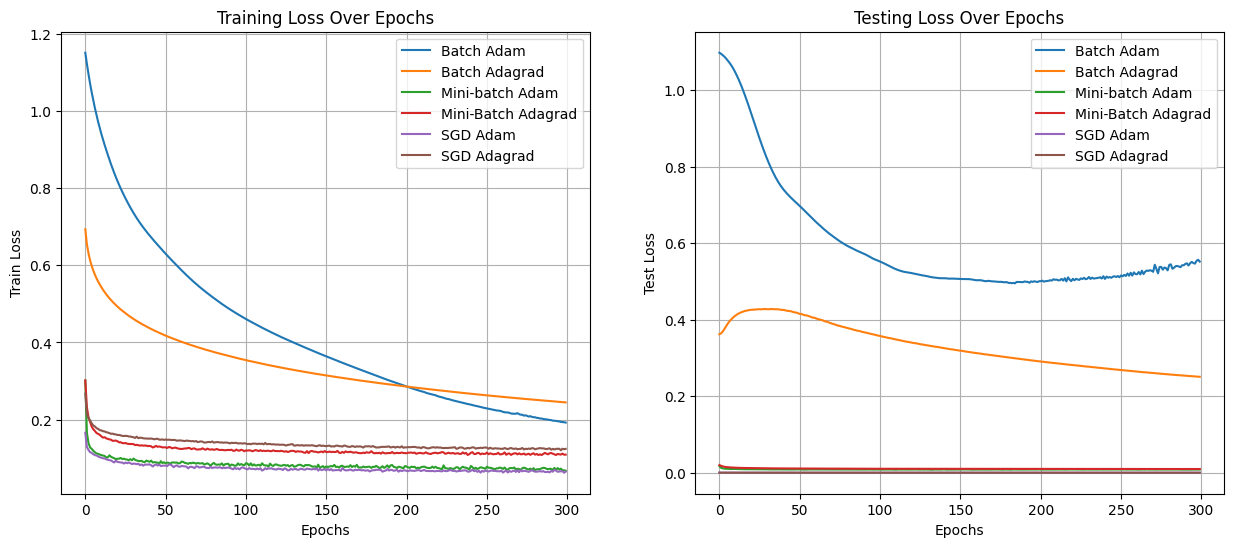

In [56]:
# Plotting losses with legend
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
for method, losses in train_losses_BN.items():
    plt.plot(losses, label=method)
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)

plt.subplot(1,2,2)
for method, losses in test_losses_BN.items():
    plt.plot(losses, label=method)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Testing Loss Over Epochs')
    plt.legend()
    plt.grid(True)
plt.show()

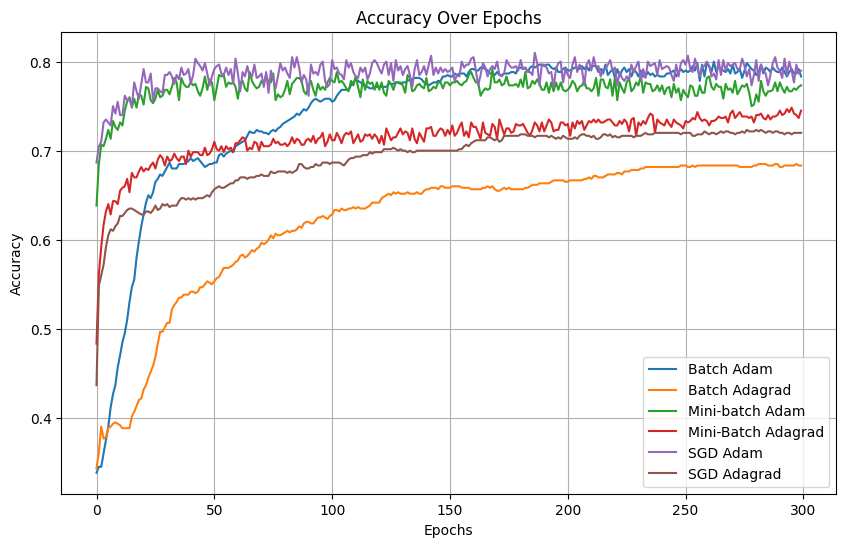

In [57]:
plt.figure(figsize=(10, 6))
for method, accuracy in model_accuracy_BN.items():
    plt.plot(accuracy, label=method)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
results = []
for method in train_losses_BN.keys():
    final_train_loss = train_losses_BN[method][-1]
    final_test_loss = test_losses_BN[method][-1]
    final_accuracy = model_accuracy_BN[method][-1]
    results.append({
        'Method': method,
        'Final Train Loss': final_train_loss,
        'Final Test Loss': final_test_loss,
        'Final Accuracy': final_accuracy
    })

results_df = pd.DataFrame(results)
display(results_df)

,Method,Final Train Loss,Final Test Loss,Final Accuracy
0,Batch Adam,0.192080,0.551725,0.783333
1,Batch Adagrad,0.244399,0.250727,0.683333
2,Mini-batch Adam,0.067245,0.008466,0.773333
3,Mini-Batch Adagrad,0.108927,0.009816,0.745000
4,SGD Adam,0.064821,0.000171,0.790000
5,SGD Adagrad,0.123875,0.000207,0.720000


# Findings and Conclusion

Used Autoencoders to reduce dimension of Traffic data from 9 features to 6 features. Increasing complexity of data and helping models to predict better.

Built a Prediction model which was trained on encoded data from autoencoder. Used batch normalization and different gradient descent methods (Full Batch, Mini-Batch, and Stochastic Gradient Descent) with Adam and Adagrad optimizers.

### Batch Normalization:
- Batch Normalization lead to faster convergence and faster training.

### Gradient Descent Methods:
- **Mini-Batch**: It helped in creating small batches of size 50 for training, which helped in achieving higher accuracy and stability than Full batch and SGD.

- **Full Batch**: It is more computationally expensive and showed slow training and convergence.

- **SGD**: It had accuracy same as mini-batch but the model is not stable and showed lot of fluctuations in training.

### Optimizers:
- Adam performed better than Adagrad in all scenarios of Gradient Descent methods, with low loss and high accuracy.

### Best Performing model:
The best performing model is mini-batch with Adam optimizer, mainly because of it's stability and faster training. Along with less fluctuations in the training loss and accuracy.

